<h1>Fine Tuning

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Number of GPUs available : ",len(physical_devices))
#tf.config.experimental.set_memory_growth(physical_devices[0],True)

Number of GPUs available :  0


<h2>Data Preperation

In [3]:
if os.path.isdir('Datasets/train/dog') is False:
    os.makedirs('Datasets/train/dog')
    os.makedirs('Datasets/test/dog')
    os.makedirs('Datasets/train/cat')
    os.makedirs('Datasets/test/cat')
    os.makedirs('Datasets/valid/dog')
    os.makedirs('Datasets/valid/cat')
    
    for c in random.sample(glob.glob('Datasets/train/cat*'),500):
        shutil.move(c, 'Datasets/train/cat')
    for c in random.sample(glob.glob('Datasets/train/dog*'),500):
        shutil.move(c, 'Datasets/train/dog')
    for c in random.sample(glob.glob('Datasets/train/cat*'),50):
        shutil.move(c, 'Datasets/test/cat')
    for c in random.sample(glob.glob('Datasets/train/dog*'),50):
        shutil.move(c, 'Datasets/test/dog')
    for c in random.sample(glob.glob('Datasets/train/cat*'),100):
        shutil.move(c, 'Datasets/valid/cat')
    for c in random.sample(glob.glob('Datasets/train/dog*'),100):
        shutil.move(c, 'Datasets/valid/dog')

In [4]:
train_path='Datasets/train'
test_path='Datasets/test'
valid_path='Datasets/valid'

In [5]:
# Preprocess Image Data for Keras
train_batches = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input
).flow_from_directory(directory=train_path, target_size=(224,224), classes=['cat', 'dog'],batch_size=10)
valid_batches = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input
).flow_from_directory(directory=valid_path, target_size=(224,224), classes=['cat', 'dog'],batch_size=10)
test_batches = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input
).flow_from_directory(directory=test_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10, shuffle=False)

Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [6]:
assert train_batches.n == 1000
assert valid_batches.n == 200
assert test_batches.n == 100
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 2

In [7]:
# Pull out the first batch of the dataset (.ie) first 10 images of the training batch
imgs, labels = next(train_batches)

In [8]:
#This function will plot images in the form of a grid with 1 row and 10 columns where images are placed in the row
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

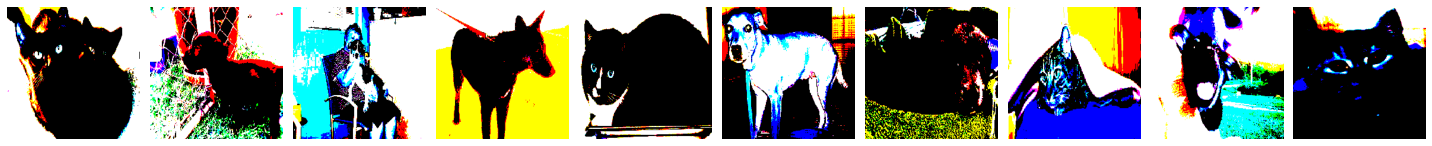

[[1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]


In [9]:
plotImages(imgs)
print(labels)

<h2>Build Fine-tuned VGG16 model

In [10]:
# Downloading VGG-16 model
vgg16_model = tf.keras.applications.vgg16.VGG16()

In [11]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [12]:
model = Sequential()
for layer in vgg16_model.layers[:-3]:
    model.add(layer)

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [14]:
for layer in model.layers:
    layer.trainable = False

In [15]:
model.add(Dense(units=2, activation='softmax'))

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

<h2>Training Fine-tuned VGG-16 model

In [17]:
model.compile(
    optimizer=Adam(learning_rate=0.0001), 
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [18]:
r = model.fit(
    x=train_batches,
    validation_data=valid_batches,
    steps_per_epoch=100,
    validation_steps=20,
    epochs=5,
    verbose=2
)

Epoch 1/5
100/100 - 270s - loss: 2.3493 - accuracy: 0.8400 - val_loss: 1.3832 - val_accuracy: 0.9100
Epoch 2/5
100/100 - 266s - loss: 0.2371 - accuracy: 0.9770 - val_loss: 1.2474 - val_accuracy: 0.9250
Epoch 3/5
100/100 - 271s - loss: 0.0147 - accuracy: 0.9970 - val_loss: 1.1795 - val_accuracy: 0.9300
Epoch 4/5
100/100 - 272s - loss: 8.3135e-05 - accuracy: 1.0000 - val_loss: 1.1736 - val_accuracy: 0.9300
Epoch 5/5
100/100 - 277s - loss: 1.9028e-05 - accuracy: 1.0000 - val_loss: 1.1724 - val_accuracy: 0.9300


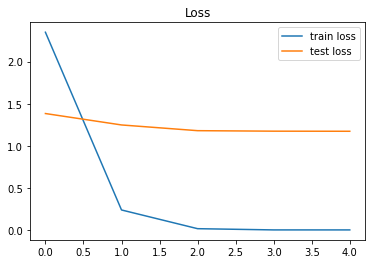

In [19]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.title('Loss')
plt.legend()
plt.show()

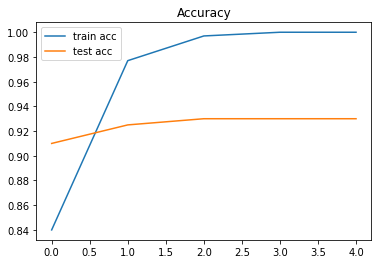

In [20]:
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='test acc')
plt.title('Accuracy')
plt.legend()
plt.show()

In [24]:
model.save('models/vgg16_fine_tuned_model.h5')

<h2>Predict using Fine-tuned VGG16 model

In [21]:
predictions = model.predict(x=test_batches, verbose=0)

In [25]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [26]:
np.round(predictions)

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.

In [27]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [28]:
def plot_confusion_matrix(cm,
                          classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues
                         ):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks=np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm=cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion Matrix")
    else:
        print("Conusion Matrix without Normalization")
        
    print(cm)
    
    thresh = cm.max()/2.
    for i, j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color='white' if cm[i, j] > thresh else "black"
                )
        plt.tight_layout()
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')

In [29]:
test_batches.class_indices

{'cat': 0, 'dog': 1}

Conusion Matrix without Normalization
[[46  4]
 [ 6 44]]


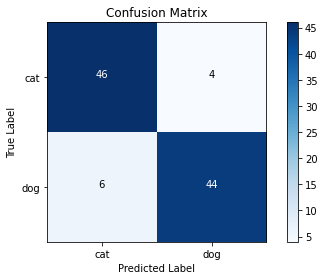

In [30]:
cm_plot_labels = ['cat', 'dog']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [31]:
acc=sum(cm.diagonal())/sum(sum(cm))*100
print("Accuracy = "+str(acc)+"%")

Accuracy = 90.0%
